In [1]:
import os
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm, inv
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
import sympy
import math
from scipy.io import loadmat
import pandas as pd
%matplotlib inline

In [2]:
def pupil_IRF(timepoints, s=1.0/(10**26), n=10.1, tmax=0.93):
    
    """ pupil_IRF defines the IRF (response to a transient input) of the pupil.
    
    Parameters
    ----------
    timepoints: timepoints to evulate function
    s: scaling factor
    n: sets the width
    tmax: sets the time to peak 
    
    Returns
    -------
    y: IRF evaluated for 'timepoints'
    y_dt: IRF first derivative evaluated for 'timepoints'
    
    """
    
    # in sympy:
    t = sympy.Symbol('t')
    y = ( (s) * (t**n) * (math.e**((-n*t)/tmax)) )
    yprime = y.diff(t)
    
    # lambdify:
    y = sympy.lambdify(t, y, "numpy")
    y_dt = sympy.lambdify(t, yprime, "numpy")
    
    # evaluate:
    y = y(timepoints)
    y_dt = y_dt(timepoints)
    
    # normalize:
    y = y/np.std(y)
    y_dt = y_dt/np.std(y_dt)
    
    return (y, y_dt)


from scipy.signal import butter, lfilter, filtfilt, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=50):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Impulse response estimation with Olympia's auditory experiment
==================================

The goal in this notebook is to fit IRF's with splines and the dt canonical IRF model.  

In [3]:
# The sampling rate of the pupil data is 1000Hz.
downsample_factor = 4
fs = 1000./downsample_factor
sample_rate = fs
# We'll use a butterworth filter of order 2 to remove trends from the data.
order = 2
# Basis length in seconds
basis_length = 3
# Load the data
a = loadmat('/Users/nwilming/Desktop/IRF.mat')
IRF = a['IRF']

Construct a spline basis for later fitting.
----------------------------------------

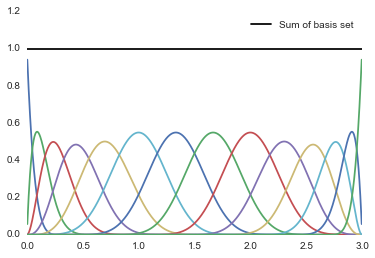

In [4]:
from ocupy import spline_base
dt = 1/fs 
length = basis_length*sample_rate
basis, knots = spline_base.spline_base1d(length, 10)
for base in basis.T:
    plot(dt*arange(length), base)
l = plot(dt*arange(length), basis.sum(1), 'k')[0]
legend([l], ['Sum of basis set'])

Show dt + canonical IRF 
---------------------

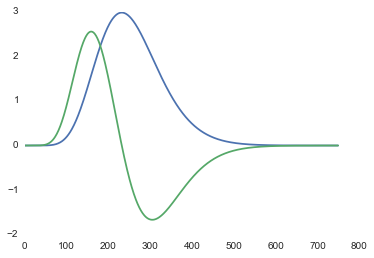

In [5]:
IRF_len = 3.0 # in seconds
timepoints = np.linspace(0,IRF_len, IRF_len*sample_rate)
cIRF, cIRF_prime = pupil_IRF(timepoints=timepoints)
plot(cIRF)
plot(cIRF_prime)

Create design matrix and to be predicted signal (filter pupil data)
---------------------------------------------------------------

In [6]:
import pandas as pd
from scipy.signal import decimate
# Convert IRF data to a data frame.
data = []
basis_str = []
for subject in range(IRF.shape[1]):
    for block in range(IRF[0, subject]['pupil'].shape[1]):        
        p = IRF[0, subject]['pupil'][0, block].flatten()
        time = decimate(arange(len(p)), downsample_factor, ftype='fir')
        p = decimate(p, downsample_factor, ftype='fir')        
        pm, ps = p.mean(), p.std()
        p = (p-pm)/ps
        p_butter = butter_bandpass_filter(p, 0.5, 8., fs, order=order)
        e = IRF[0, subject]['events'][0, block].flatten()        
        predictor = 0*ones(p.shape)
        idx = [argmin(abs(time-x)) for x in e]
        predictor[idx] = 1        
        d = {}
        for i, base in enumerate(basis.T):
            base = base/base.max()
            pc = (sp.convolve(predictor, base, 'full'))[:-(base.shape[0]-1)]
            d['bs%i'%i] = pc
            basis_str.append('bs%i'%i)
        d['cIRF'] = (sp.convolve(predictor, cIRF, 'full'))[:-(base.shape[0]-1)]
        d['cIRFprime'] = (sp.convolve(predictor, cIRF_prime, 'full'))[:-(base.shape[0]-1)]
        d.update({'block':array([block]*len(p)), 'subject':array([subject]*len(p)), 'pupil':p, 'pupil_filtered':p_butter, 'events':predictor})
        data.append(d)
data = pd.concat([pd.DataFrame(d) for d in data])

In [7]:
import patsy as pt
data_f = data[data.subject==0]

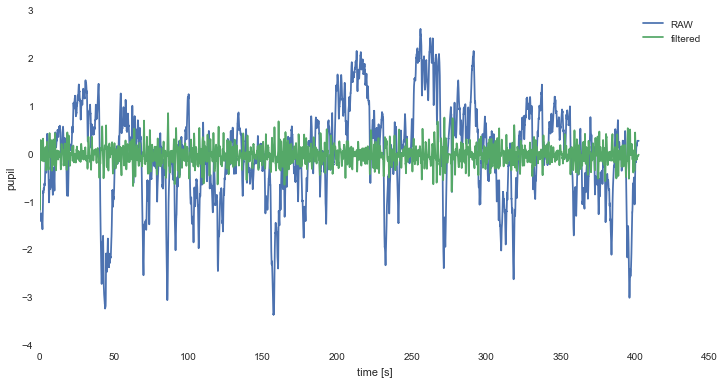

In [8]:
figure(figsize=(12,6))
plot(arange(len(data_f))*dt, data_f.pupil)
plot(arange(len(data_f))*dt, data_f.pupil_filtered)
legend(['RAW', 'filtered'])
xlabel('time [s]')
ylabel('pupil')

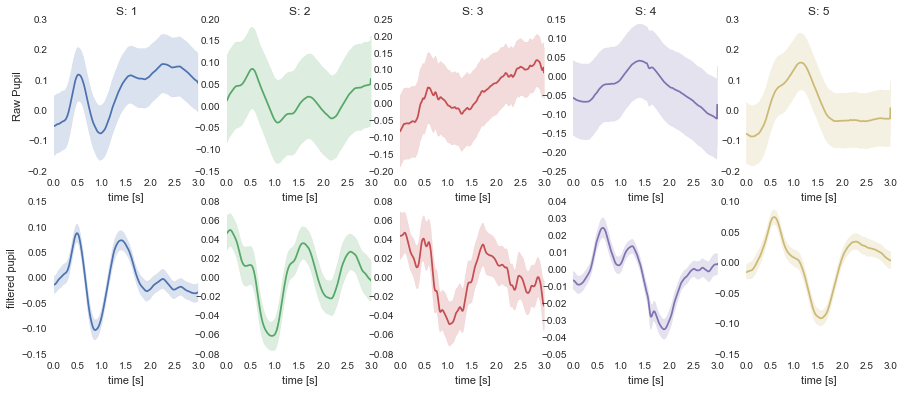

In [10]:
from matplotlib import gridspec
figure(figsize=(15,6))
# Construct event related averages
colors = sns.color_palette()
gs = gridspec.GridSpec(2, 5)
for sub, subd in data.groupby('subject'):
    subplot(gs[0, sub])

    events = where(subd.events>0)[0]
    acc = []
    for event in events:
        pp = subd.pupil[int(event):int(event+fs*basis_length)]
        pp = pad(pp, (0, int(fs*basis_length)-len(pp)), mode='constant')
        acc.append(pp)
    acc = vstack(acc)
    sns.tsplot(acc, time=dt*arange(basis_length*fs), color=colors[sub])
    if sub == 0:
        ylabel('Raw Pupil')
    xlabel('time [s]')    
    title('S: %i'%(sub+1))
    
    subplot(gs[1,sub])
    events = where(subd.events>0)[0]
    acc = []
    for event in events:
        pp = subd.pupil_filtered[int(event):int(event+fs*basis_length)]
        pp = pad(pp, (0, int(fs*basis_length)-len(pp)), mode='constant')
        acc.append(pp)
    acc = vstack(acc)
    sns.tsplot(acc, time=dt*arange(basis_length*fs),color=colors[sub])
    xlabel('time [s]')
    if sub == 0:
        ylabel('filtered pupil')

Make design matrices for OLS estimation
-------------------------------------

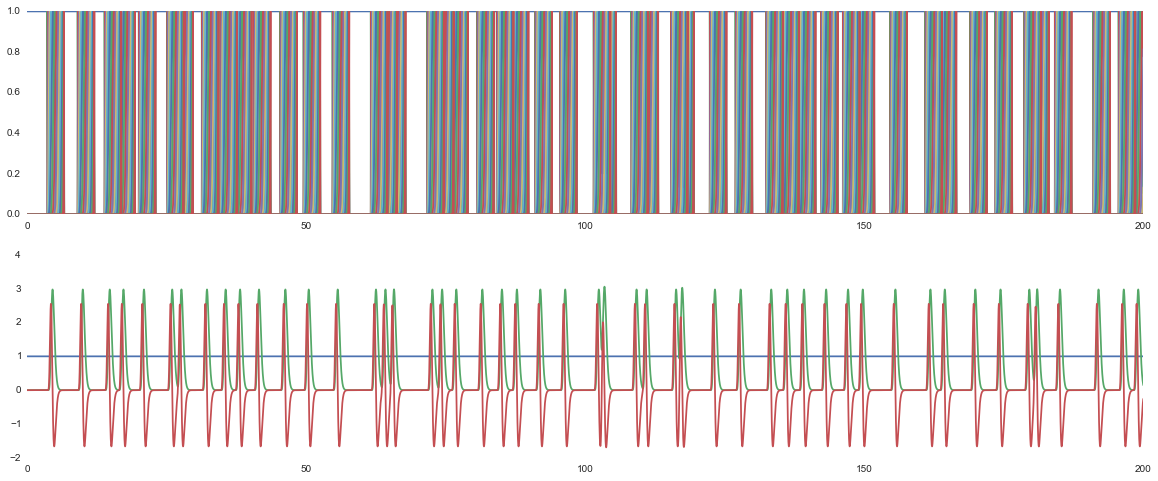

In [11]:
model_string = '+'.join(basis_str)
pupil, design = pt.dmatrices('pupil_filtered ~ %s + 1'%model_string, data_f)
figure(figsize=(20,8))
subplot(2,1,1)
mp, spupil =  pupil.mean(), pupil.std()
pupil = (pupil-mp)/spupil

plot(arange(50000)*dt, design[:50000, :])

subplot(2,1,2)
pupil2, design_irf = pt.dmatrices('pupil_filtered ~ cIRF + cIRFprime + 1', data_f)
mp, spupil =  pupil2.mean(), pupil2.std()
pupil2 = (pupil2-mp)/spupil
plot(arange(50000)*dt, design_irf[:50000, :])

Now fit both models for one test subject
--------------------------------------

In [12]:
import statsmodels.api as sm

model = sm.OLS(pupil, design)
results = model.fit()
print r'spline model R**2 %2.4f'%results.rsquared

model = sm.OLS(pupil2, design_irf)
results_irf = model.fit()
print r'canonical model R**2 %2.4f'%results_irf.rsquared

spline model R**2 0.0402
canonical model R**2 0.0047


Compare the predicted and actual values
-------------------------------------

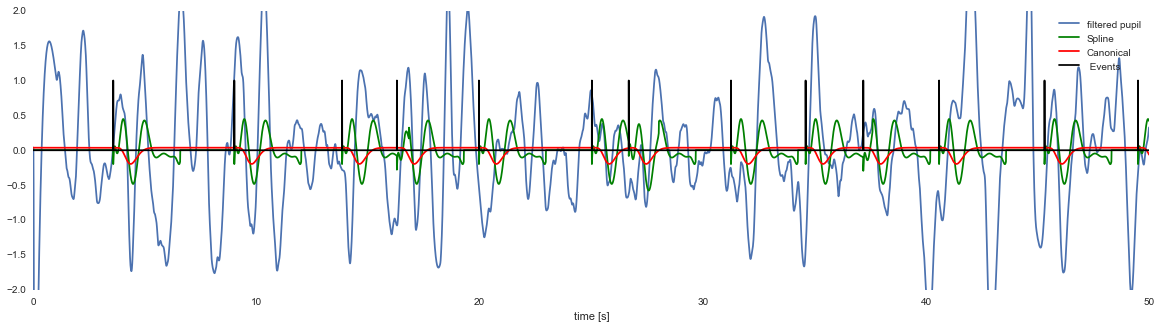

In [13]:
figure(figsize=(20,5))
idx = int(50*sample_rate)
plot(arange(idx)*dt, pupil[:idx] )
plot(arange(idx)*dt, results.fittedvalues[:idx], 'g')
plot(arange(idx)*dt, results_irf.fittedvalues[:idx], 'r')
plot(arange(idx)*dt, data_f.events[:idx], 'k')
ylim([-2, 2])
legend(['filtered pupil', 'Spline', 'Canonical', ' Events'])
xlabel('time [s]')

Plot estimated IRFs
------------------

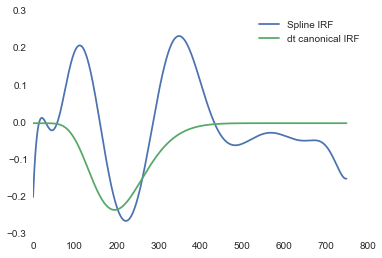

In [14]:
#print design.design_info
plot(dot(results.params[1:], basis.T ))
plot(results_irf.params[1]*cIRF+results_irf.params[2]*cIRF_prime)
legend(['Spline IRF', 'dt canonical IRF'])

Repeat for all subjects
----------------------

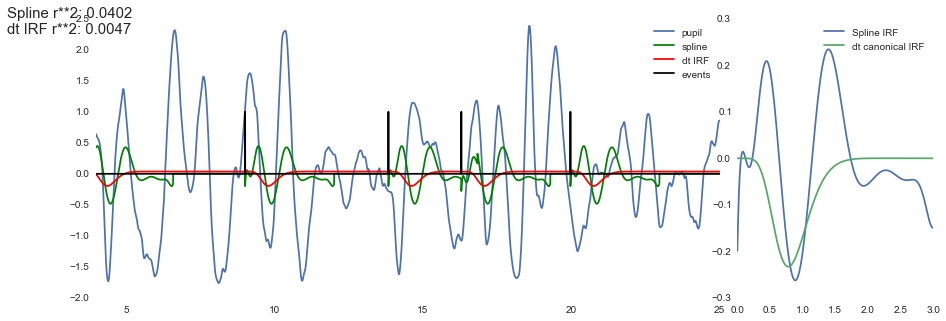

In [ ]:
# Now do all subjs.
from matplotlib import gridspec
gs = GridSpec(1, 8)
for sub_nr, subject in data.groupby('subject'):
    model_string = '+'.join(basis_str)
    pupil, design = pt.dmatrices('pupil_filtered ~ %s + 1'%model_string, subject)
    mp, spupil =  pupil.mean(), pupil.std()
    pupil = (pupil-mp)/spupil
    pupil2, design_irf = pt.dmatrices('pupil_filtered ~ cIRF + cIRFprime + 1', subject)
    mp, spupil =  pupil2.mean(), pupil2.std()
    pupil2 = (pupil2-mp)/spupil
    model = sm.OLS(pupil, design)
    results = model.fit()
    
    model = sm.OLS(pupil2, design_irf)
    results_irf = model.fit()
    
    figure(figsize=(15,5))
    subplot(gs[:, :6])
    idx = 25*int(sample_rate)
    plot(arange(1000,idx)*dt, pupil[1000:idx] )
    plot(arange(1000,idx)*dt, results.fittedvalues[1000:idx], 'g')
    plot(arange(1000,idx)*dt, results_irf.fittedvalues[1000:idx], 'r')
    plot(arange(1000,idx)*dt, subject.events[1000:idx], 'k')
    xlim([1000*dt, idx*dt])
    legend(['pupil', 'spline', 'dt IRF', 'events'])

    text(1, 2, 'Spline r**2: %0.4f \ndt IRF r**2: %0.4f \n'%(results.rsquared, results_irf.rsquared), fontdict={'fontsize':15})
    subplot(gs[:, 6:])
    l = dot(results.params[1:], basis.T ).shape[0]
    
    plot(arange(l)*dt, dot(results.params[1:], basis.T ))
    plot(arange(l)*dt, results_irf.params[1]*cIRF+results_irf.params[2]*cIRF_prime)
    
    legend(['Spline IRF', 'dt canonical IRF'])
    
    